In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client(n_workers=28)
client

Client Scheduler: tcp://127.0.0.1:38743 Dashboard: /proxy/8787/status,Cluster Workers: 28 Cores: 28 Memory: 269.74 GB


In [3]:
db = '/scratch/e14/rmh561/access-om2/archive/databases/cc_database_omip'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
    ('1 OMIP2 cycle 1',  {'expt':'1deg_jra55_iaf_omip2','cy':1,'color':'C0'}),
    ('1 OMIP2 cycle 2',  {'expt':'1deg_jra55_iaf_omip2_cycle2','cy':2,'color':'C0'}),
    ('1 OMIP2 cycle 3',  {'expt':'1deg_jra55_iaf_omip2_cycle3','cy':3,'color':'C0'}),
    ('1 OMIP2 cycle 4',  {'expt':'1deg_jra55_iaf_omip2_cycle4','cy':4,'color':'C0'}),
    ('1 OMIP2 cycle 5',  {'expt':'1deg_jra55_iaf_omip2_cycle5','cy':5,'color':'C0'}),
    ('1 OMIP2 cycle 6',  {'expt':'1deg_jra55_iaf_omip2_cycle6','cy':6,'color':'C0'}),
#    ('025 OMIP2 cycle 1',   {'expt':'025deg_jra55_iaf_cycle1'}),
#    ('025 OMIP2 cycle 2',   {'expt':'025deg_jra55_iaf_cycle2'}),
    ('025 OMIP2 cycle 1 oldtopo',  {'expt':'025deg_jra55_iaf_newIC','cy':1,'color':'C1'}),   
    ('025 OMIP2 cycle 1 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle1','cy':1,'color':'C2'}),
    ('025 OMIP2 cycle 2 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle2','cy':2,'color':'C2'}),
    ('025 OMIP2 cycle 3 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle3','cy':3,'color':'C2'}),
    ('025 OMIP2 cycle 4 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle4','cy':4,'color':'C2'}),
    ('025 OMIP2 cycle 5 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle5','cy':5,'color':'C2'}),
    ('025 OMIP2 cycle 6 newtopo',   {'expt':'025deg_jra55_iaf_amoctopo_cycle6','cy':6,'color':'C2'}),
    ('025 RYF',   {'expt':'025deg_jra55_ryf9091_gadi','cy':1,'color':'C3'}),
])
exptdict_noRYF = copy.deepcopy(exptdict)
del exptdict_noRYF['025 RYF']

## Just checking the final data for each expt.

In [5]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,ncfile='ocean_scalar.nc')
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '2263-01-01'
print(' Setting end_time to',end_time)

1deg_jra55_iaf_omip2 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle2 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle3 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle4 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle5 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle6 goes from 1958 to 2018
025deg_jra55_iaf_newIC goes from 1958 to 2017
025deg_jra55_iaf_amoctopo_cycle1 goes from 1958 to 2018
025deg_jra55_iaf_amoctopo_cycle2 goes from 1958 to 2018
025deg_jra55_iaf_amoctopo_cycle3 goes from 1958 to 2018
025deg_jra55_iaf_amoctopo_cycle4 goes from 1958 to 2018
025deg_jra55_iaf_amoctopo_cycle5 goes from 1958 to 2018
025deg_jra55_iaf_amoctopo_cycle6 goes from 1958 to 2018
025deg_jra55_ryf9091_gadi goes from 1900 to 2499
 Setting end_time to 2263-01-01


## Scalar diagnostics

In [6]:
def plot_timeseries(variable,end_time,keys=exptdict.keys(),ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time,ncfile=ncfile)
        var = var.resample(time='Y').mean()#.plot(label=ekey)
        tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(var.time))]
        if (exptdict[ekey]['cy'] == 1):
            plt.plot(tL,var.values,label=ekey,color=exptdict[ekey]['color'])
        else:
            plt.plot(tL,var.values,color=exptdict[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.xlim([0.,61*6+1])
    xlims = plt.xlim()
    ylims = plt.ylim()
    for x in range(5):
        plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 26.1 s, sys: 1.08 s, total: 27.2 s
Wall time: 28.1 s


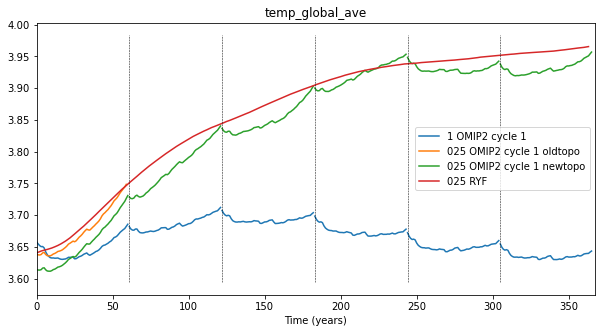

In [7]:
%%time
plot_timeseries('temp_global_ave',end_time,ncfile='ocean_scalar.nc')

### Global Average Salinity

CPU times: user 25.2 s, sys: 1.01 s, total: 26.2 s
Wall time: 26.7 s


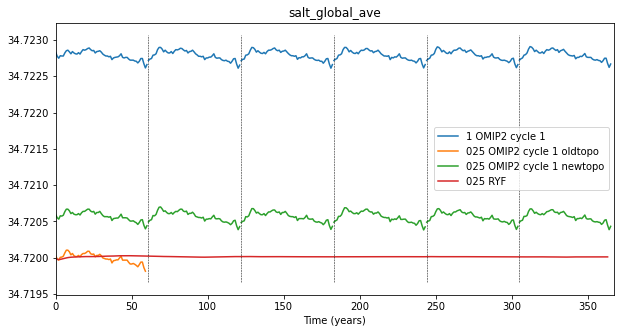

In [8]:
%%time
plot_timeseries('salt_global_ave',end_time,ncfile='ocean_scalar.nc')

### Surface Temperature

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 6min 14s, sys: 12 s, total: 6min 26s
Wall time: 6min 27s


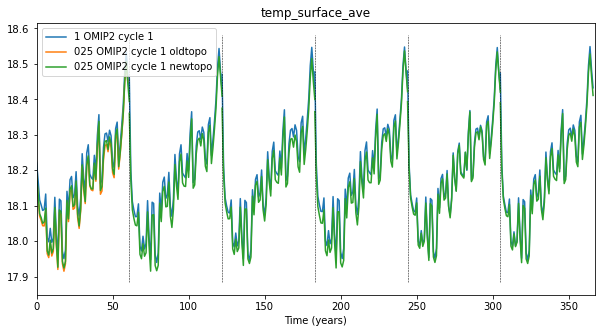

In [7]:
%%time
plot_timeseries('temp_surface_ave',end_time,ncfile='ocean_scalar_snapshot.nc',keys=exptdict_noRYF.keys())

### Surface Salinity

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 6min 18s, sys: 10.9 s, total: 6min 29s
Wall time: 6min 31s


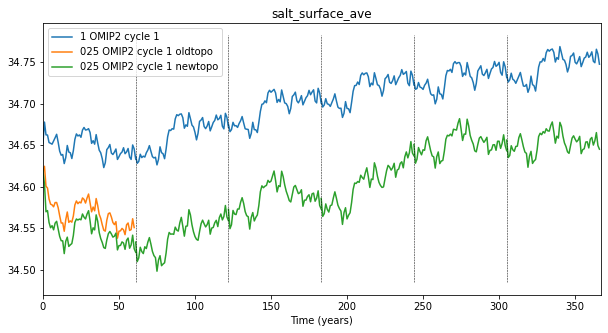

In [8]:
%%time
plot_timeseries('salt_surface_ave',end_time,ncfile='ocean_scalar_snapshot.nc',keys=exptdict_noRYF.keys())

### Total Kinetic Energy

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


CPU times: user 26.7 s, sys: 1.24 s, total: 28 s
Wall time: 28.8 s


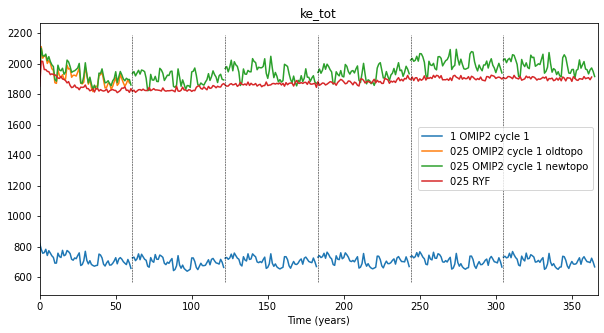

In [12]:
%%time
plot_timeseries('ke_tot',end_time,ncfile='ocean_scalar.nc')

## Area-Averaged Tracer Diagnostics

In [11]:
def plot_depthintv(variable,end_time,zlims,keys=exptdict.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        area = cc.querying.getvar(expt,'area_t',session,n=1)
        dzt = cc.querying.getvar(expt,'dht',session,n=1).isel(time=0)
        vol = (dzt*area).sel(st_ocean = slice(zlims[0],zlims[1]))
        var = var.sel(st_ocean = slice(zlims[0],zlims[1]))
        varmean = ((var*vol).sum('st_ocean').sum('yt_ocean').sum('xt_ocean')/(vol.sum('st_ocean').sum('yt_ocean').sum('xt_ocean'))).resample(time='Y').mean()
        (varmean-273.15).plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm ' + variable)

### Upper 700m temp

In [12]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[0.,700.],keys=keys)

025deg_jra55_iaf_cycle1


distributed.core - ERROR - 'tcp://127.0.0.1:33411'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://127.0.0.1:33411'
distributed.utils - ERROR - 'tcp://127.0.0.1:33411'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site

KilledWorker: ("('sum-1bf9743943199829327fe71cb65aea33', 496, 0, 4, 0)", <Worker 'tcp://127.0.0.1:37103', name: 15, memory: 0, processing: 42464>)

<Figure size 720x360 with 0 Axes>

### Upper 2000m temp

025deg_jra55_iaf_cycle1


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
CPU times: user 36min 21s, sys: 3min 15s, total: 39min 36s
Wall time: 41min 12s


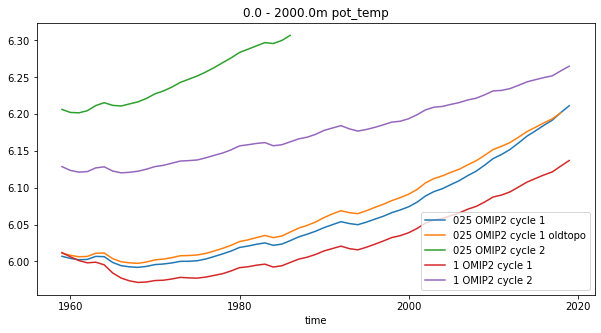

In [13]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[0.,2000.],keys=keys)

### 2000m-bottom temp

In [ ]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[2000.,10000.],keys=keys)

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


### Plots to make (XXXX):
- Temperature and salinity drifts compared to WOA13

## Circulation Diagnostics

### Drake Passage Transport

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle3


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle4


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle5


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle6


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle3


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


CPU times: user 1min 18s, sys: 2.73 s, total: 1min 21s
Wall time: 1min 32s


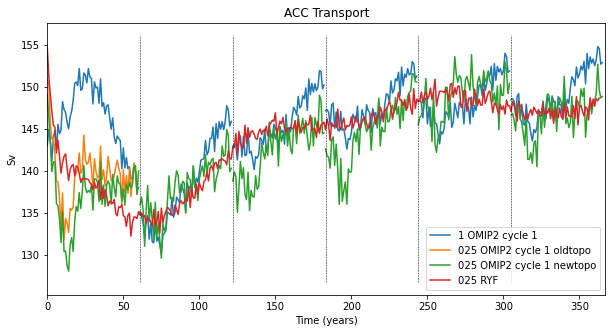

In [9]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    #DP.plot(label=ekey)
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(DP.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,DP.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,DP.values,color=exptdict[ekey]['color'])
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()

### AABW overturning circulation @ 55°S

1deg_jra55_iaf_omip2


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle2


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle3


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle5


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle3
025deg_jra55_iaf_amoctopo_cycle4
025deg_jra55_iaf_amoctopo_cycle5
025deg_jra55_iaf_amoctopo_cycle6
025deg_jra55_ryf9091_gadi
GM term not found
CPU times: user 13min 8s, sys: 27.8 s, total: 13min 35s
Wall time: 13min 51s


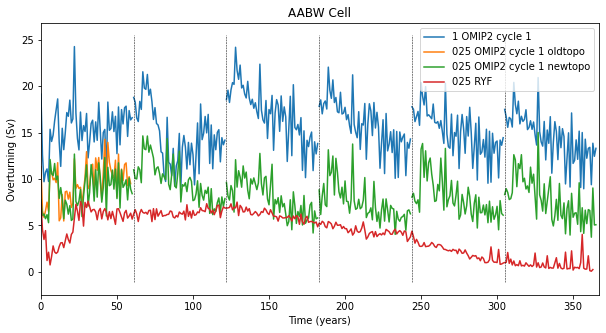

In [10]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,end_time=end_time)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(psi_aabw_sum.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,psi_aabw_sum.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,psi_aabw_sum.values,color=exptdict[ekey]['color'])
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()

## AABW overturning at 30S:

1deg_jra55_iaf_omip2


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle2


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle3


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle4


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle5


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle6


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle3


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi
GM term not found


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 14min 4s, sys: 32.6 s, total: 14min 36s
Wall time: 15min 3s


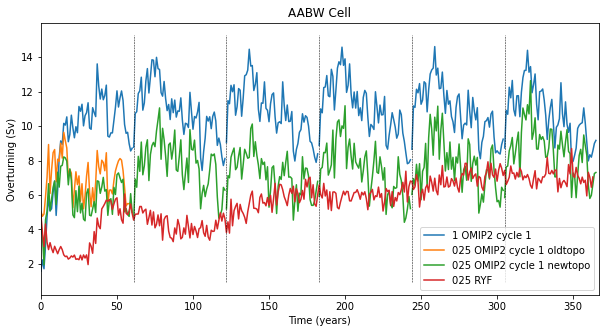

In [26]:
%%time
latitude=-30
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,end_time=end_time)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(psi_aabw_sum.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,psi_aabw_sum.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,psi_aabw_sum.values,color=exptdict[ekey]['color'])
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()

### AMOC Overturning in density space @ 26°N

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle3
1deg_jra55_iaf_omip2_cycle4
1deg_jra55_iaf_omip2_cycle5
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1
025deg_jra55_iaf_amoctopo_cycle2
025deg_jra55_iaf_amoctopo_cycle3
025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


GM term not found


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 7min 49s, sys: 16.6 s, total: 8min 6s
Wall time: 8min 25s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

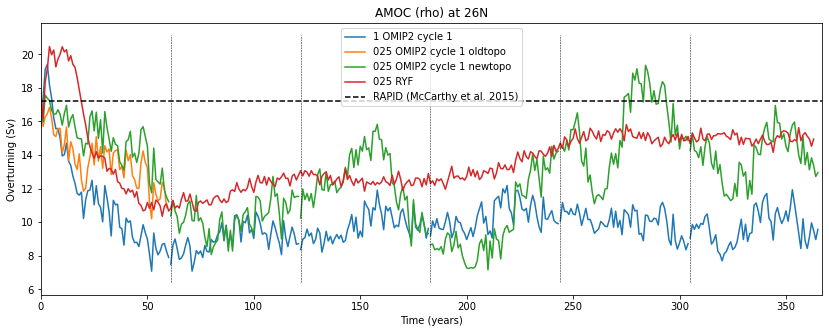

In [11]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,end_time=end_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(psi_amoc_sum.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,psi_amoc_sum.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,psi_amoc_sum.values,color=exptdict[ekey]['color'])

#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()
plt.title('AMOC (rho) at 26N')

### AMOC Overturning in depth space @ 26°N

1deg_jra55_iaf_omip2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle3


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle4


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle5


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle6


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle3


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi
GM term not found
CPU times: user 9min 31s, sys: 22.1 s, total: 9min 53s
Wall time: 10min 16s


Text(0.5, 1.0, 'AMOC (z) at 26N')

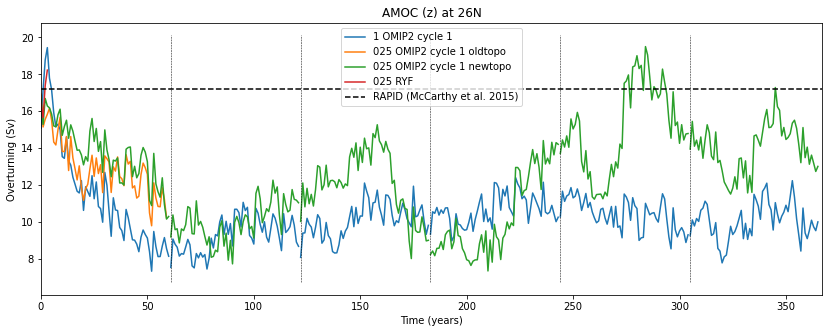

In [12]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans',session,end_time=end_time)
    psi_amoc = var.sel(xt_ocean=slice(-103,-5)).sum('xt_ocean').sel(method='Nearest',yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('st_ocean') - psi_amoc.sum('st_ocean')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_gm',session,end_time=end_time)
        psi_amoc_gm = var2.sel(xt_ocean=slice(-103,-5)).sum('xt_ocean').sel(method='Nearest',yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(st_ocean=slice(200.,2500.)).max('st_ocean').resample(time='Y').mean()
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(psi_amoc_sum.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,psi_amoc_sum.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,psi_amoc_sum.values,color=exptdict[ekey]['color'])

#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()
plt.title('AMOC (z) at 26N')

### Indonesian Throughflow

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle3
1deg_jra55_iaf_omip2_cycle4


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle5
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2
025deg_jra55_iaf_amoctopo_cycle3


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5
025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


CPU times: user 1min 22s, sys: 3.33 s, total: 1min 25s
Wall time: 1min 38s


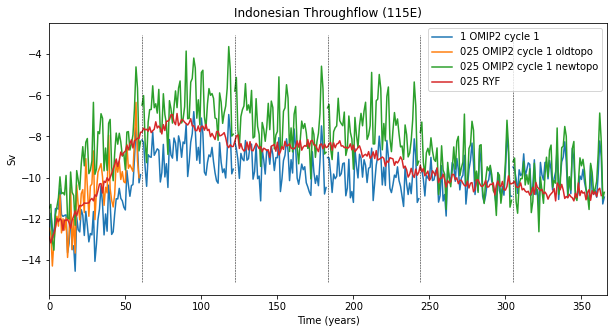

In [13]:
%%time

xmin=115.0-360.
ymin=-22.
ymax=-8.25

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    #DP.plot(label=ekey)
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(DP.time))]
    if (exptdict[ekey]['cy'] == 1):
        plt.plot(tL,DP.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        plt.plot(tL,DP.values,color=exptdict[ekey]['color'])

plt.title("Indonesian Throughflow (115E)")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.xlim([0.,61*6+1])
xlims = plt.xlim()
ylims = plt.ylim()
for x in range(5):
    plt.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
plt.legend()

### Plots to make (XXXX):
- Meridional heat transport
- Eastern Pacific zonal velocity

## Global Overturning Streamfunction (density)

In [14]:
def plot_psi(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi
GM term not found


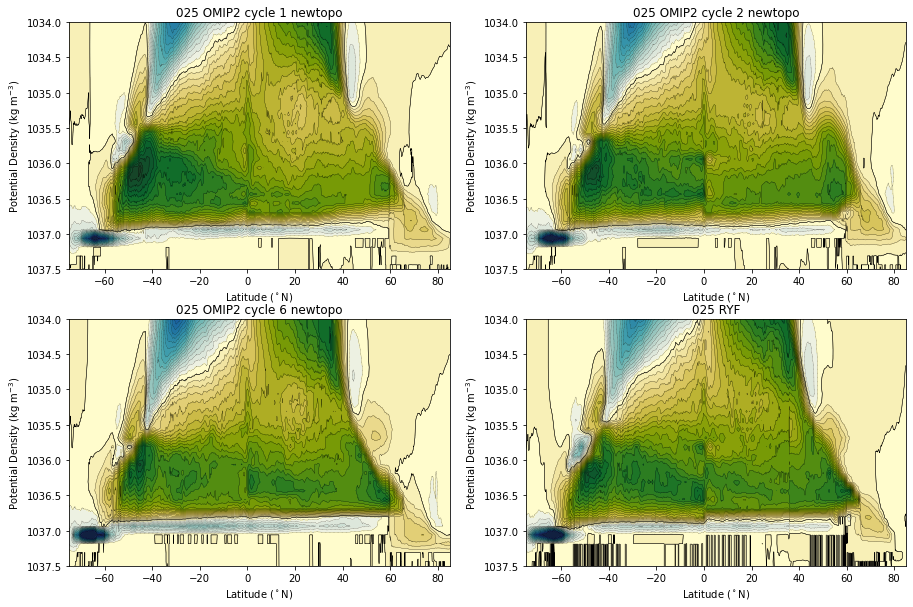

In [15]:
plt.figure(figsize=(15,10))
ii=0
#keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo','025 RYF']
keys = ['025 OMIP2 cycle 1 newtopo','025 OMIP2 cycle 2 newtopo','025 OMIP2 cycle 6 newtopo','025 RYF']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time='2016-01-01',end_time='2018-01-01')
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time='2016-01-01',end_time='2018-01-01')
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi
GM term not found


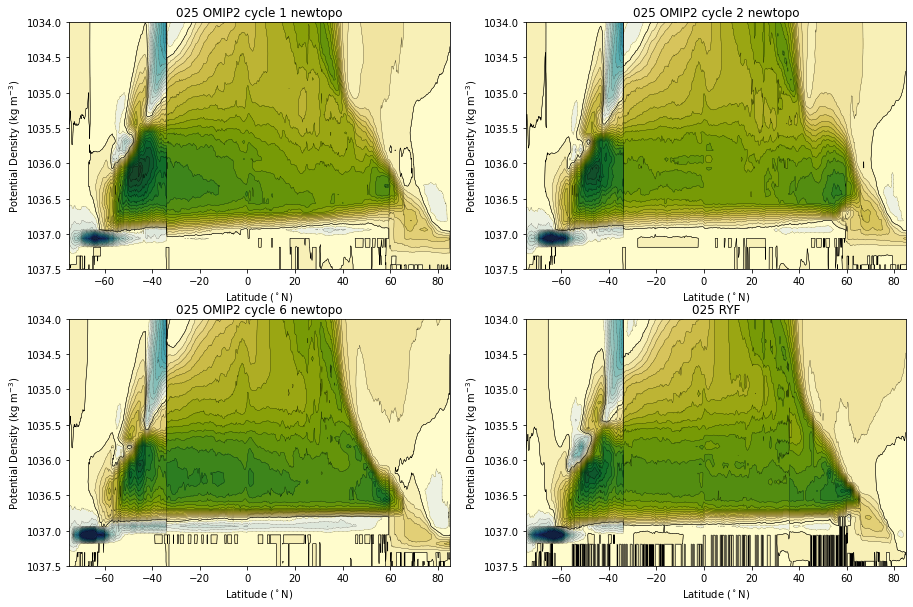

In [16]:
# Atlantic mask:
plt.figure(figsize=(15,10))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo','025 RYF']
keys = ['025 OMIP2 cycle 1 newtopo','025 OMIP2 cycle 2 newtopo','025 OMIP2 cycle 6 newtopo','025 RYF']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    
    # Atlantic mask:
    ht = cc.querying.getvar(expt,'ht',session,n=-1)
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time='2016-01-01',end_time='2018-01-01')
    psi = var
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    psi = (psi*atlantic_sector_mask).sum('grid_xt_ocean').mean('time')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time='2016-01-01',end_time='2018-01-01')
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

In [17]:
def plot_psi_z(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.yu_ocean, 
                 psi_avg.st_ocean, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.yu_ocean, 
                psi_avg.st_ocean, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.yu_ocean,
                psi_avg.st_ocean, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

025deg_jra55_iaf_amoctopo_cycle1
025deg_jra55_iaf_amoctopo_cycle2
025deg_jra55_iaf_amoctopo_cycle6


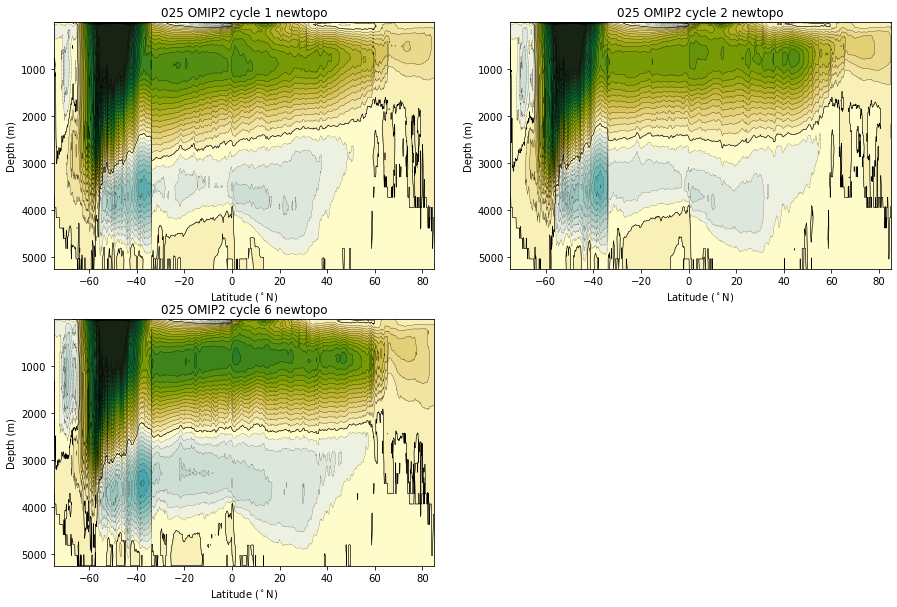

In [18]:
# Atlantic mask:
plt.figure(figsize=(15,10))
ii=0
keys = ['025 OMIP2 cycle 1 newtopo','025 OMIP2 cycle 2 newtopo','025 OMIP2 cycle 6 newtopo']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    
    # Atlantic mask:
    ht = cc.querying.getvar(expt,'ht',session,n=-1)
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

    var = cc.querying.getvar(expt,'ty_trans',session,start_time='2017-01-01',end_time='2018-01-01')
    psi = var
    atlantic_sector_mask.coords['xt_ocean'] = psi.xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'yt_ocean':'yu_ocean'})
    psi = (psi*atlantic_sector_mask).sum('xt_ocean').mean('time')*1.0e-9
    psi_avg = psi.cumsum('st_ocean') -  psi.sum('st_ocean')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_gm',session,start_time='2016-01-01',end_time='2018-01-01')
        psi_gm = var2.mean('time').sum('xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi_z(psi_avg)
    plt.title(ekey)

### Ice Area (in both hemispheres)

025deg_jra55_ryf9091_gadi


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle1


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle3


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle4


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle5


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


025deg_jra55_iaf_amoctopo_cycle6


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Text(0.5, 1.0, 'Southern Ocean')

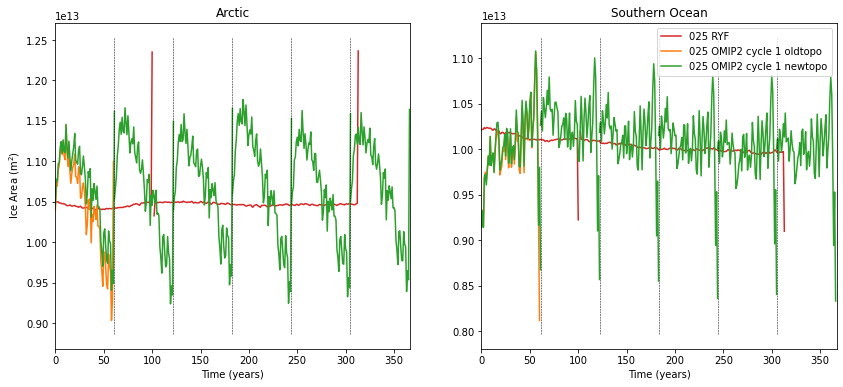

In [25]:
variable='aice_m'
fig,axes = plt.subplots(1,2,figsize=(14,6))
keys = ['025 RYF','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 newtopo','025 OMIP2 cycle 2 newtopo','025 OMIP2 cycle 3 newtopo','025 OMIP2 cycle 4 newtopo','025 OMIP2 cycle 5 newtopo','025 OMIP2 cycle 6 newtopo']
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').resample(time='Y').mean().load()
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
    
    
    #NH_area.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey)
    #SH_area.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey) 
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(NH_area.time))]
    if (exptdict[ekey]['cy'] == 1):
        axes[0].plot(tL,NH_area.values,label=ekey,color=exptdict[ekey]['color'])
        axes[1].plot(tL,SH_area.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        axes[0].plot(tL,NH_area.values,color=exptdict[ekey]['color'])
        axes[1].plot(tL,SH_area.values,color=exptdict[ekey]['color'])

#    psi_amoc_sum.plot(label=ekey)#,)

axes[0].set_ylabel(' Ice Area (m$^2$)')
for ax in axes:
    ax.set_xlim([0.,61*6+1])
    xlims = [0.,61*6+1]
    ylims = ax.get_ylim()
    for x in range(5):
        ax.set_xlabel('Time (years)')
        ax.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
axes[1].legend()
axes[0].set_title('Arctic')
axes[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = ['025 RYF','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 newtopo','025 OMIP2 cycle 2 newtopo','025 OMIP2 cycle 3 newtopo','025 OMIP2 cycle 4 newtopo','025 OMIP2 cycle 5 newtopo','025 OMIP2 cycle 6 newtopo']
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').resample(time='Y').mean().load()
    #NH_vol.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
    #SH_vol.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey)
    
    tL = [x+(exptdict[ekey]['cy']-1)*61 for x in range(len(NH_vol.time))]
    if (exptdict[ekey]['cy'] == 1):
        ax[0].plot(tL,NH_vol.values,label=ekey,color=exptdict[ekey]['color'])
        ax[1].plot(tL,SH_vol.values,label=ekey,color=exptdict[ekey]['color'])
    else:
        ax[0].plot(tL,NH_vol.values,color=exptdict[ekey]['color'])
        ax[1].plot(tL,SH_vol.values,color=exptdict[ekey]['color'])

#    psi_amoc_sum.plot(label=ekey)#,)

ax[0].set_ylabel('Ice Volume (m$^3$)')
for ax in ax:
    ax.set_xlim([0.,61*6+1])
    xlims = ax.xlim()
    ylims = ax.ylim()
    for x in range(5):
        ax.set_xlabel('Time (years)')
        ax.plot([61.*(x+1),61.*(x+1)],ylims,'--k',linewidth=0.5)
ax[1].legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


## North Atlantic Sills/max density

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1


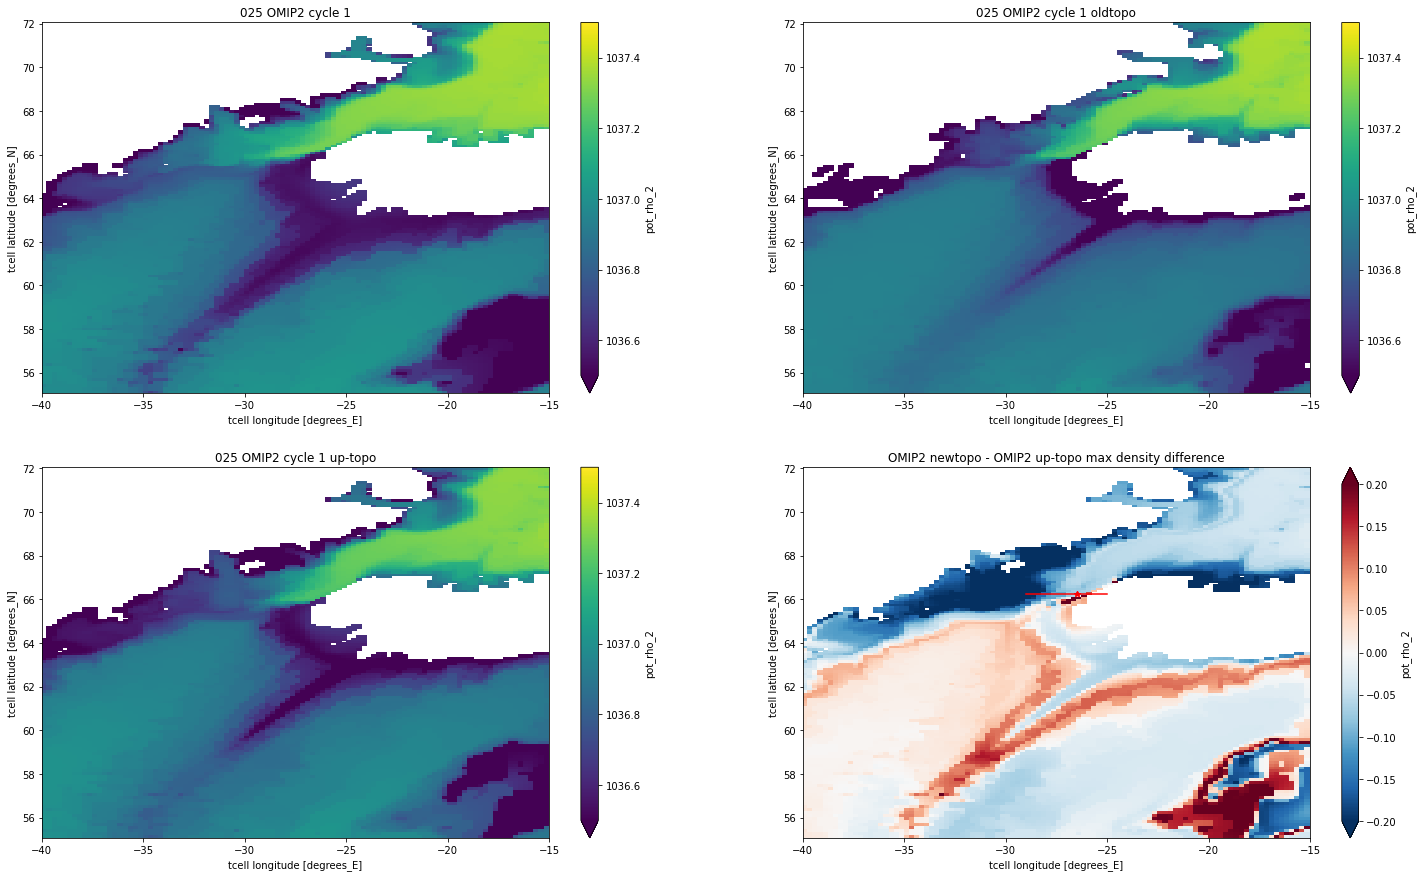

In [22]:
# Maximum density in Denmark Strait:

plt.figure(figsize=(25,15))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo']
for ekey in keys:
    ii+=1
    axs = plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    dens = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
    dens = dens.sel(xt_ocean=slice(-40.,-15.)).sel(yt_ocean=slice(55.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')
    dens.plot(ax=axs,vmin=1036.5,vmax=1037.5)
    plt.title(ekey)
    
# Difference in densities new-topo and updated:
expt = exptdict['025 OMIP2 cycle 1']['expt']
dens_cont = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
dens_cont = dens_cont.sel(xt_ocean=slice(-40.,-15.)).sel(yt_ocean=slice(55.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')
expt = exptdict['025 OMIP2 cycle 1 up-topo']['expt']
dens = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
dens = dens.sel(xt_ocean=slice(-40.,-15.)).sel(yt_ocean=slice(55.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')

axs = plt.subplot(2,2,4)
(dens-dens_cont).plot(ax = axs,vmin=-0.2,vmax=0.2,cmap='RdBu_r')
plt.title('OMIP2 newtopo - OMIP2 up-topo max density difference')
plt.plot([-26.5,-26.5],[66.25,66.25],'*r')
plt.plot([-29.,-25.],[66.25,66.25],'-r')

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1


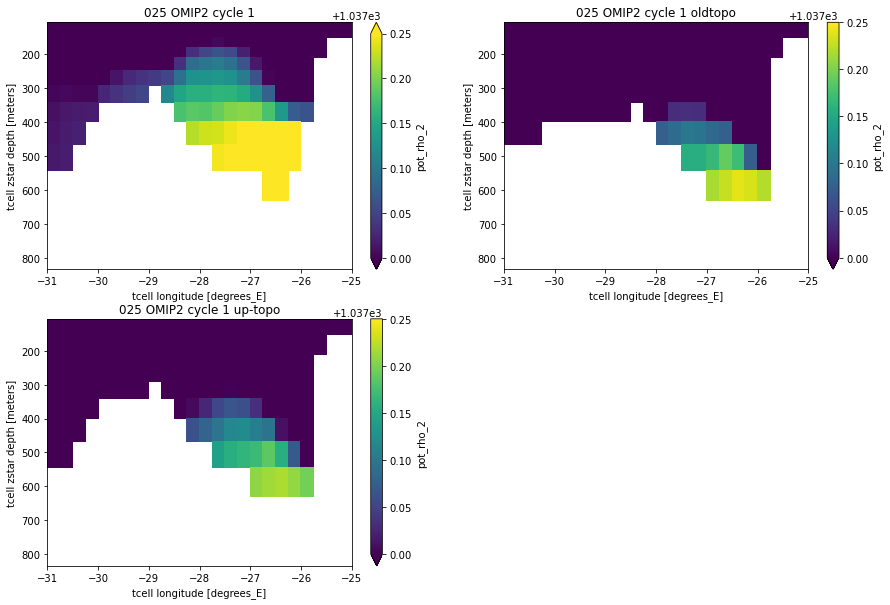

In [21]:
# Cross-section:
plt.figure(figsize=(15,10))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo']
for ekey in keys:
    ii+=1
    axs = plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    dens = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
    dens = dens.sel(xt_ocean=slice(-31.,-25.)).sel(yt_ocean=66.25,method='nearest').mean('time').sel(st_ocean=slice(100.,800.))
    dens.plot(ax=axs,vmin=1037.0,vmax=1037.25)
    axs.invert_yaxis()
    plt.title(ekey)

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1


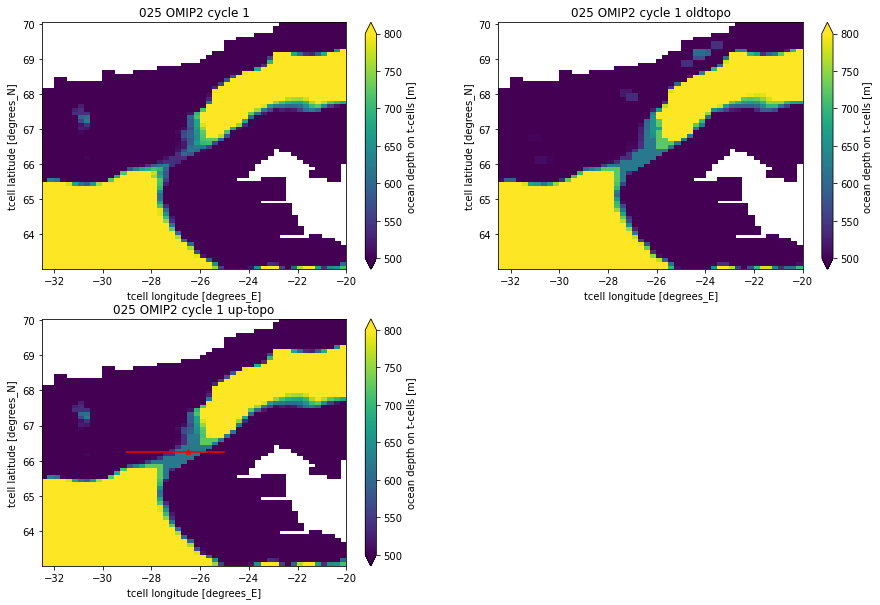

In [17]:
# Topography:
plt.figure(figsize=(15,10))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo']
for ekey in keys:
    ii+=1
    axs = plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    dens = cc.querying.getvar(expt,'ht',session,start_time='2017-01-01',end_time='2018-01-01')
    dens = dens.sel(xt_ocean=slice(-32.5,-20.)).sel(yt_ocean=slice(63.,70.))
    dens.plot(ax=axs,vmin=500.,vmax=800.)
    plt.title(ekey)
plt.plot([-26.5,-26.5],[66.25,66.25],'*r')
plt.plot([-29.,-25.],[66.25,66.25],'-r')

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1


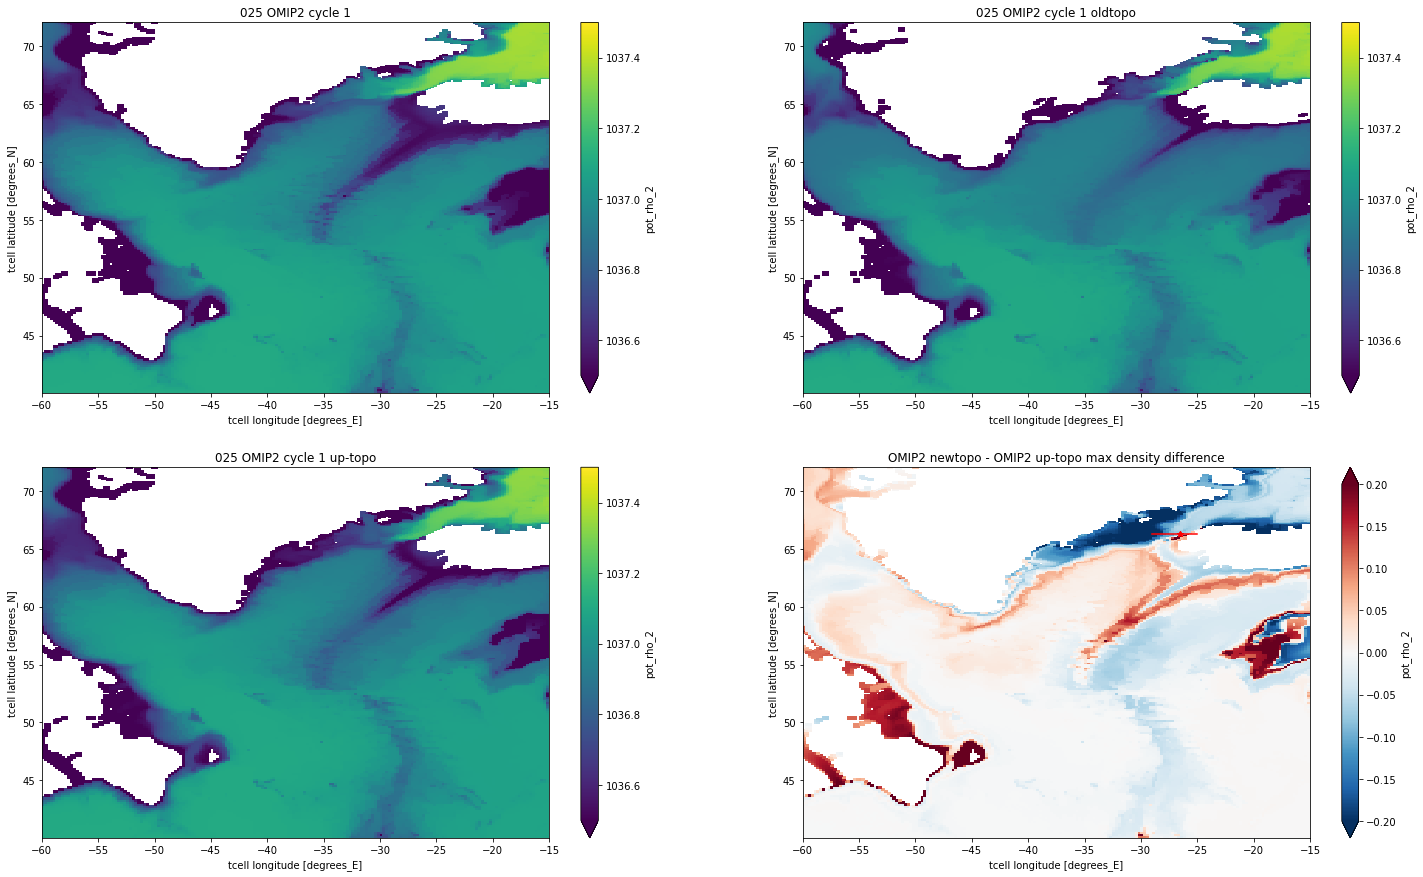

In [23]:
# Maximum density:
plt.figure(figsize=(25,15))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo']
for ekey in keys:
    ii+=1
    axs = plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    dens = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
    dens = dens.sel(xt_ocean=slice(-60.,-15.)).sel(yt_ocean=slice(40.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')
    dens.plot(ax=axs,vmin=1036.5,vmax=1037.5)
    plt.title(ekey)
    
# Difference in densities new-topo and updated:
expt = exptdict['025 OMIP2 cycle 1']['expt']
dens_cont = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
dens_cont = dens_cont.sel(xt_ocean=slice(-60.,-15.)).sel(yt_ocean=slice(40.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')
expt = exptdict['025 OMIP2 cycle 1 up-topo']['expt']
dens = cc.querying.getvar(expt,'pot_rho_2',session,start_time='2010-01-01',end_time='2018-01-01')
dens = dens.sel(xt_ocean=slice(-60.,-15.)).sel(yt_ocean=slice(40.,72.)).sel(st_ocean=slice(200.,None)).max('st_ocean').mean('time')

axs = plt.subplot(2,2,4)
(dens-dens_cont).plot(ax = axs,vmin=-0.2,vmax=0.2,cmap='RdBu_r')
plt.title('OMIP2 newtopo - OMIP2 up-topo max density difference')
plt.plot([-26.5,-26.5],[66.25,66.25],'*r')
plt.plot([-29.,-25.],[66.25,66.25],'-r')

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_amoctopo_cycle1


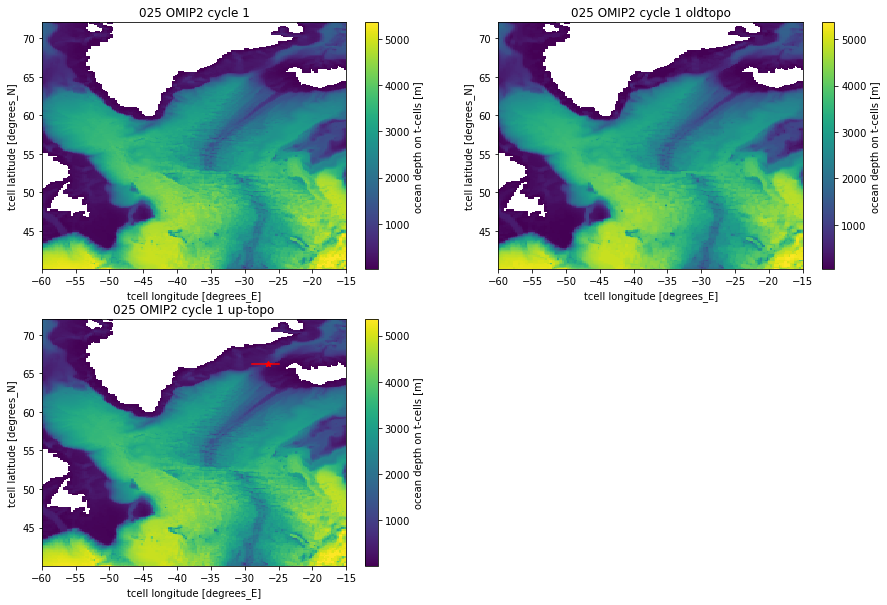

In [25]:
# Topography:
plt.figure(figsize=(15,10))
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 1 up-topo']
for ekey in keys:
    ii+=1
    axs = plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    dens = cc.querying.getvar(expt,'ht',session,start_time='2017-01-01',end_time='2018-01-01')
    dens = dens.sel(xt_ocean=slice(-60,-15.)).sel(yt_ocean=slice(40.,72.))
    dens.plot(ax=axs)
    plt.title(ekey)
plt.plot([-26.5,-26.5],[66.25,66.25],'*r')
plt.plot([-29.,-25.],[66.25,66.25],'-r')

## Issues that I ran into:

### Potential vs. Conservative Temperature

- SST should be potential temperature - as this is what goes into the bulk formula.

- `bottom_pot_temp`, `pot_temp_surface_ave`, `pot_temp_global_ave` diagnostics don't exist - must be calculated offline. Note: `surface_ave` differences are negligible by construction. `pot_temp_global_ave` should not be used in a TEOS-10 model (not related to heat content).

- Out of range issues on diagnostic squared potential temperature output created GB-sized `.err` text files.

- Note: new McDougall manuscript will advocate for interpreting potential temperature of EOS-80 models as Conservative Temperature (as it is assumed to be conserved in these models). In TEOS-10 models Conservative Temperature should be used for all heat content calculations (except that SST variables should be potential temperature).

### Numerical issues

- New topography – needed to add Rayleigh drag in Kara Strait to avoid ice CFL issues. Still ended up using `dt=1350s` not `1800s`.

- Ice thermo errors – had to drop the time step to `900s` twice in cycle 1, and once (so far) in cycle 2. This was an issue in the 1/10th - fixed with mushy ice?

## Storage / Timing

- Output is 76GB/year (56GB ocean, 20GB ice). Equivalent to 4.5TB/cycle or 30TB (including extra 3TB for last cycle monthly budget diags) for six cycles (+ restarts).

- Currently getting about 12 years / day. => 22 days to completion.

- 7.2 kSU/year cost (compared to 5.9 kSU/year reported in NCMAS). Total cost ~2.6MSU.
